# GTHA housing market database
# OSEMN methodology Step 4: Model
# Two features
---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist

In [3]:
def plot_decision_regions(X, y, classifier, test_idx=None,  
                          resolution=0.02, limits=False, alpha=0.05,
                          minx=-0.5, maxx=1, miny=-0.8, maxy=2):

    # setup marker generator and color map
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.figure(figsize=(12, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=alpha, c=colors[idx],
                    marker=markers[idx], label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')
    
    
        
    if limits:
        ax = plt.gca()
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

## Load Teranet data

In [4]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
t = time()

df = pd.read_csv(data_path + '4_Teranet_lu_encode.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 101.21 seconds (1.69 minutes)
with 5,188,513 rows
and 75 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'pin_years_since_last_sale', 'xy_years_since_last_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'pin_sale_next_6m', 'pin_sale_next_1y', 'pin_sale_next_3y',
       'xy_sale_next_6m', 'xy_sale_next_1y', 'xy_sale_next_3y', 'price_2016',
       'pin_price_cum_sum', 'xy_price_cum_sum', 'p

## Take a subset of Teranet records

In [6]:
year = 2011
s = df.query('year == @year')
print("{0:,} records in the subset".format(len(s)))

219,130 records in the subset


## Take a validation subset of Teranet records

In [7]:
year_val = 2012
s_val = df.query('year == @year_val')
print("{0:,} records in the subset".format(len(s_val)))

205,341 records in the subset


## Select features

In [8]:
feat_1 = 'price_to_med_year'
feat_2 = 'xy_years_since_last_sale'

s = s.dropna(subset=[feat_1, feat_2])
s_val = s_val.dropna(subset=[feat_1, feat_2])

## Exploratory Data Analysis (EDA)

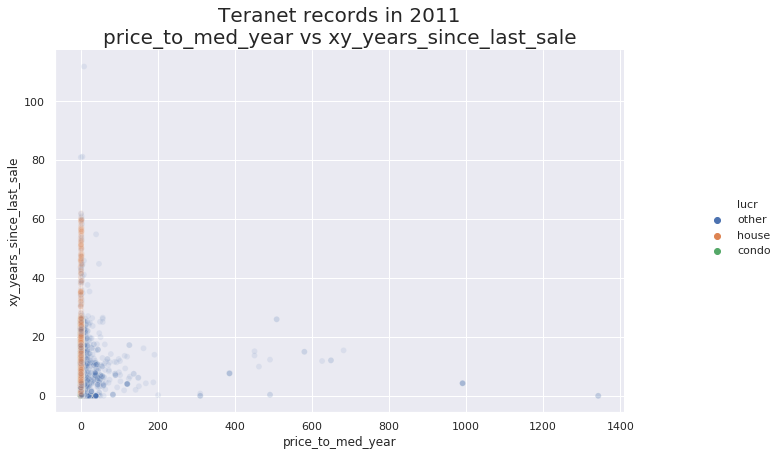

In [9]:
g = sns.relplot(data=s, x=feat_1, y=feat_2, hue='lucr', alpha=0.1)
g.fig.set_size_inches(12, 6)
ax = plt.gca()
ax.set_title("Teranet records in {0}\n{1} vs {2}".format(year, feat_1, feat_2), fontsize=20)
plt.show()

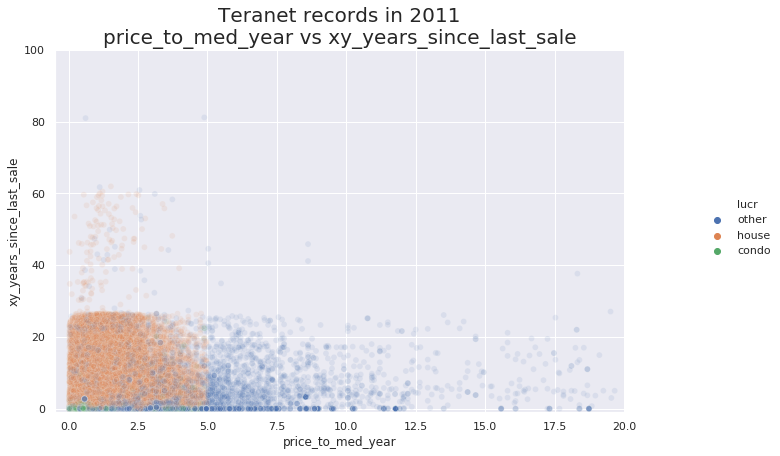

In [10]:
g = sns.relplot(data=s, x=feat_1, y=feat_2, hue='lucr', alpha=0.1)
g.fig.set_size_inches(12, 6)
ax = plt.gca()
ax.set_title("Teranet records in {0}\n{1} vs {2}".format(year, feat_1, feat_2), fontsize=20)
ax.set_xlim(-0.5, 20)
ax.set_ylim(-1, 100)
plt.show()

## Prepare features and target

### Encode target

In [11]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
print("Land use encoded!")
labels = {0: 'condo', 1: 'house', 2: 'other'}
labels_list = ['condo', 'house', 'other']
s['lucr_e'].value_counts().sort_index()

Land use encoded!


0    62144
1    62551
2    66378
Name: lucr_e, dtype: int64

In [12]:
le = LabelEncoder()
s_val['lucr_e'] = le.fit_transform(s_val['lucr'])
print("Land use encoded!")
s_val['lucr_e'].value_counts().sort_index()

Land use encoded!


0    54994
1    61450
2    60059
Name: lucr_e, dtype: int64

In [13]:
labels

{0: 'condo', 1: 'house', 2: 'other'}

#### Select features and target

In [14]:
X = s[[feat_1, feat_2]].values
y = s['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [15]:
X_val = s_val[[feat_1, feat_2]].values
y_val = s_val['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")

Performed train-test split.


In [17]:
len(X_train)

133751

In [18]:
len(y_train)

133751

In [19]:
len(X_test)

57322

In [20]:
len(y_test)

57322

In [21]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val:', np.bincount(y_val))

Labels counts in y: [62144 62551 66378]
Labels counts in y_train: [43501 43786 46464]
Labels counts in y_test: [18643 18765 19914]
Labels counts in y_val: [54994 61450 60059]


#### Standardize features

In [22]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print("Input features were standardized.")

Input features were standardized.


In [23]:
X_val_std = sc.transform(X_val)
print("Input features were standardized.")

Input features were standardized.


#### Recombine inputs and targets

In [24]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
print("Input and target recombined.")

Input and target recombined.


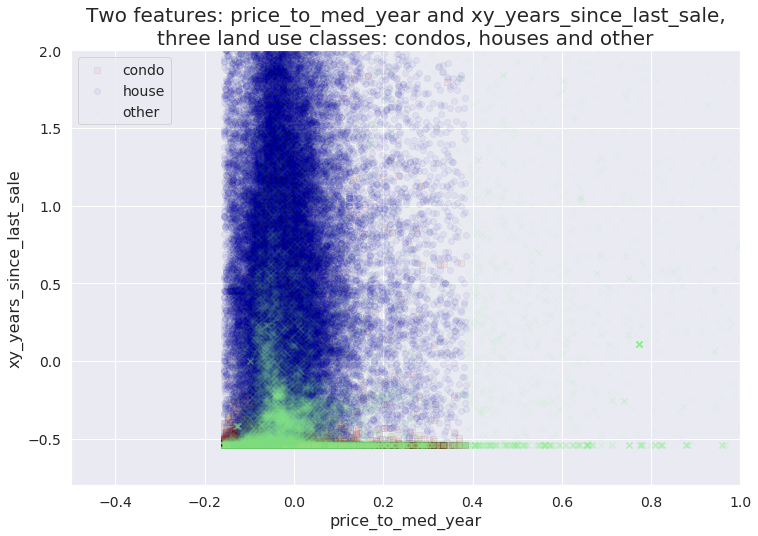

In [25]:
markers = ('s', 'o', 'x', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_combined))])
plt.figure(figsize=(12, 8))
for idx, cl in enumerate(np.unique(y_combined)):
    plt.scatter(x=X_combined_std[y_combined == cl, 0], y=X_combined_std[y_combined == cl, 1],
                c=colors[idx], marker=markers[idx], label=cl, edgecolor='black', alpha=0.05)
plt.xlim(-0.5, 1)
plt.ylim(-0.8, 2)
plt.xlabel(feat_1, fontsize=16)
plt.ylabel(feat_2, fontsize=16)
plt.title("Two features: {0} and {1},\nthree land use classes: condos, houses and other"
          .format(feat_1, feat_2),
          fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
plt.show()

### Train and test classification algorithms

#### Perceptron learning algorithm

In [26]:
t = time()

# initialize and fit a model
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
ppn.fit(X_train_std, y_train)

# make predictions
y_pred_train = ppn.predict(X_train_std)
y_pred_test = ppn.predict(X_test_std)
y_pred_val = ppn.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

Model fit, took 0.24 seconds (0.00 minutes)


Plotting took 2.89 seconds (0.05 minutes)


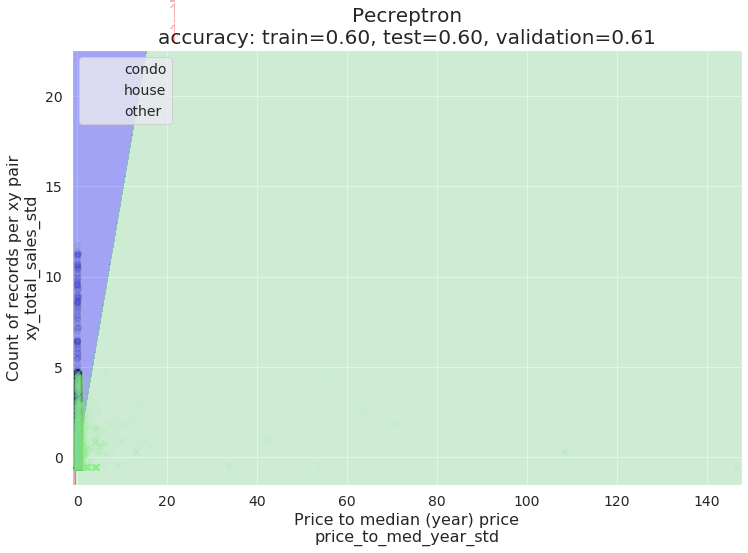

In [27]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Pecreptron\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 3.33 seconds (0.06 minutes)


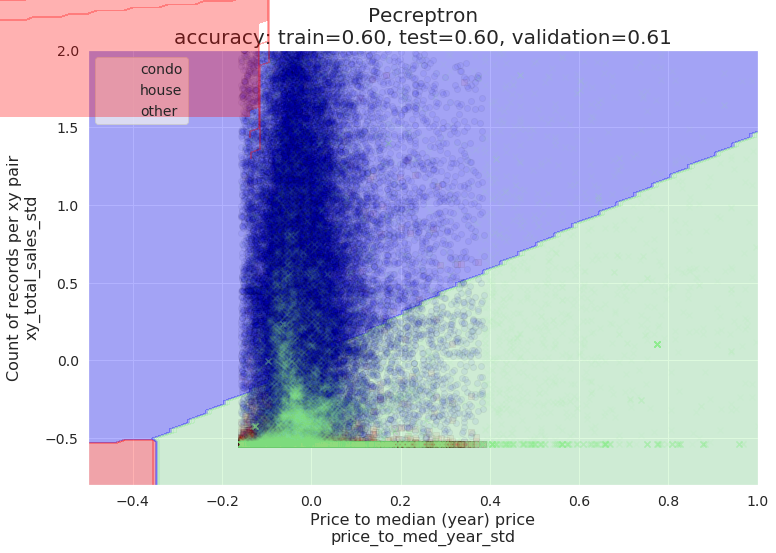

In [28]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Pecreptron\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Logistic regression

In [29]:
t = time()

# initialize and fit a model
model = LogisticRegression(C=100.0, random_state=1)
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("Model fit, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model fit, took 0.84 seconds (0.01 minutes)


Plotting took 3.17 seconds (0.05 minutes)


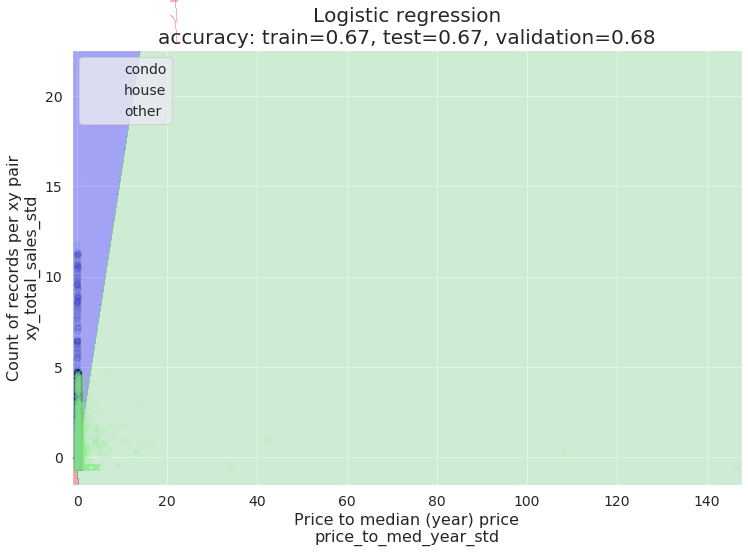

In [30]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Logistic regression\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 3.18 seconds (0.05 minutes)


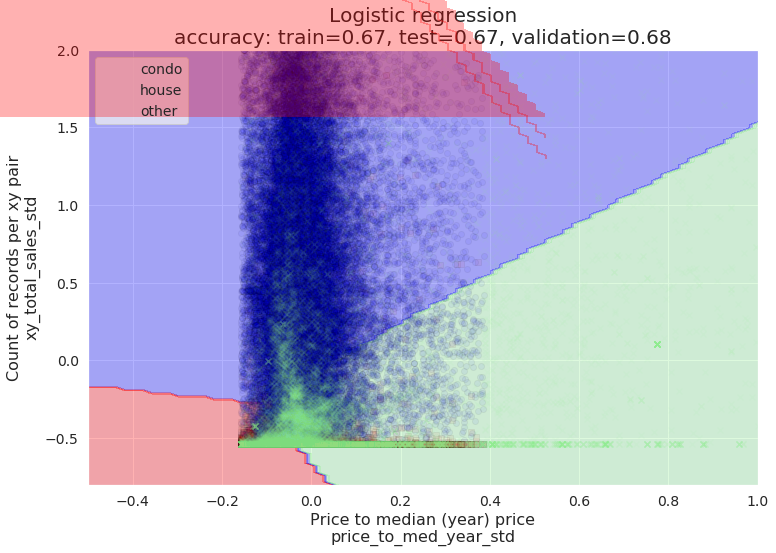

In [31]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("Logistic regression\naccuracy: train={0:.2f}, test={1:.2f}, validation={2:.2f}"
          .format(train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Decision Tree

In [32]:
t = time()

# initialize and fit a model
model = DecisionTreeClassifier(criterion='gini',
                              max_depth=4, 
                              random_state=1)
model_name = 'Decision Tree'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

Decision Tree fit, took 0.15 seconds (0.00 minutes)


Plotting took 3.08 seconds (0.05 minutes)


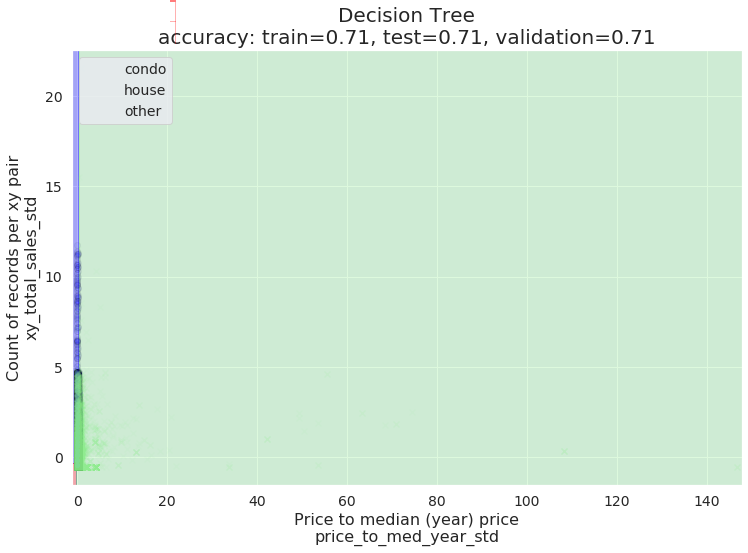

In [33]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 2.91 seconds (0.05 minutes)


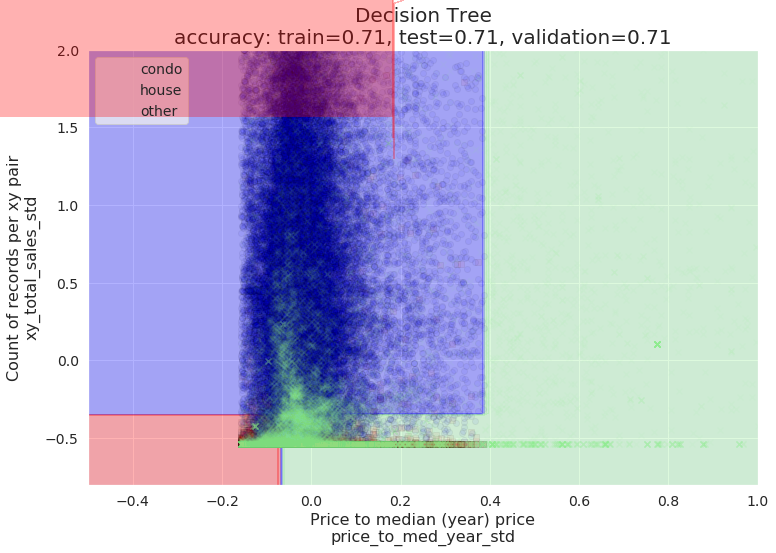

In [34]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### Random Forest

In [35]:
t = time()

# initialize and fit a model
model = RandomForestClassifier(criterion='gini',
                               n_estimators=25,
                               random_state=1,
                               n_jobs=2)
model_name = 'Random Forest'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

Random Forest fit, took 6.29 seconds (0.10 minutes)


Plotting took 12.89 seconds (0.21 minutes)


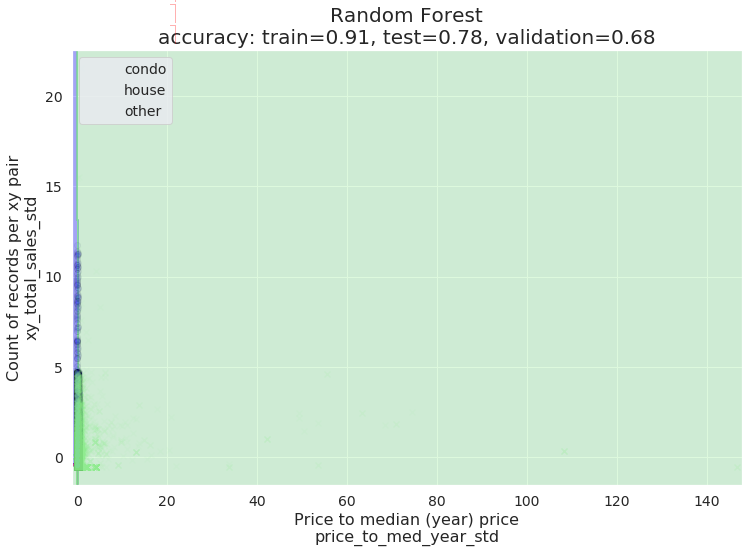

In [36]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 12.74 seconds (0.21 minutes)


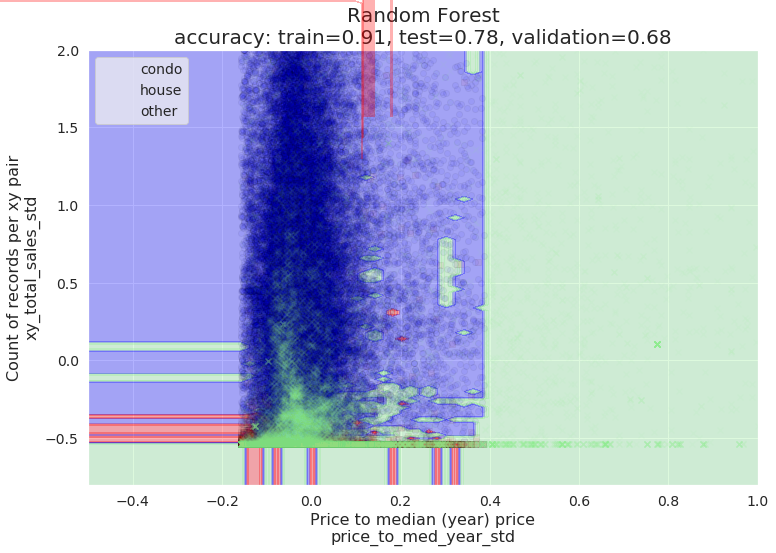

In [37]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

#### K-nearest neighbors

In [38]:
t = time()

# initialize and fit a model
model = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
model_name = 'K-nearest neighbors'
model.fit(X_train_std, y_train)

# make predictions
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)
y_pred_val = model.predict(X_val_std)

# score model performance
train_score = accuracy_score(y_train, y_pred_train)
test_score = accuracy_score(y_test, y_pred_test)
val_score = accuracy_score(y_val, y_pred_val)

elapsed = time() - t
print("{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))

K-nearest neighbors fit, took 25.51 seconds (0.43 minutes)


Plotting took 500.36 seconds (8.34 minutes)


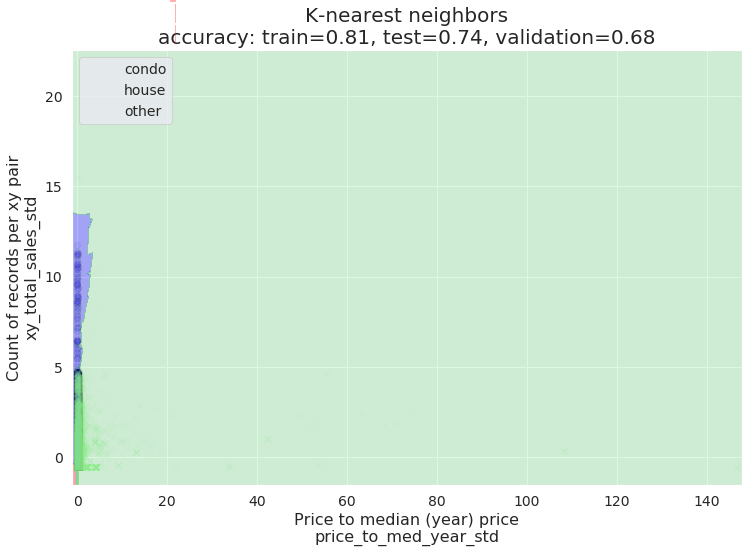

In [39]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=False)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()

Plotting took 502.34 seconds (8.37 minutes)


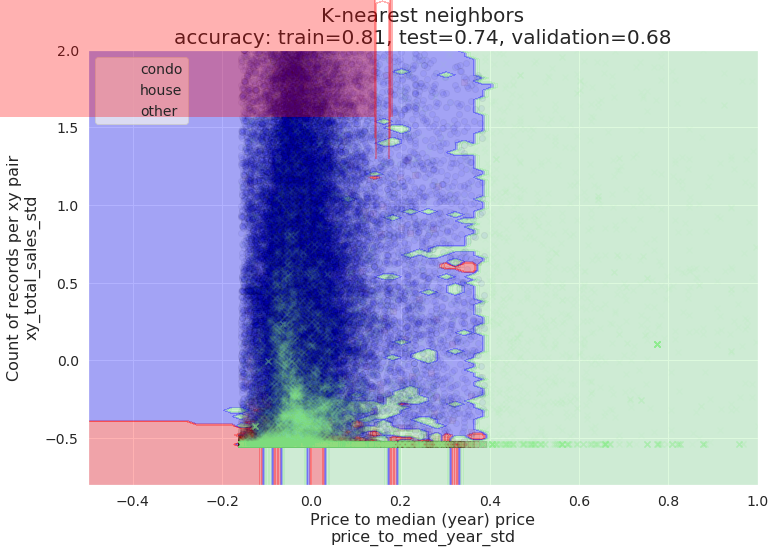

In [40]:
t = time()
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=model,
                      limits=True)
plt.xlabel("Price to median (year) price\nprice_to_med_year_std", fontsize=16)
plt.ylabel("Count of records per xy pair\nxy_total_sales_std", fontsize=16)
plt.title("{0}\naccuracy: train={1:.2f}, test={2:.2f}, validation={3:.2f}"
          .format(model_name, train_score, test_score, val_score), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=labels_list, loc='upper left', fontsize=14)
elapsed = time() - t
print("Plotting took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
plt.show()